In [1]:
import pdb
import numpy as np
from astropy.wcs import WCS
from shift import shift_twod
from VieroLibrary.dist_idl import dist_idl
from VieroLibrary import readcol
from lmfit import Parameters, minimize, fit_report
from smoothmap import smoothmap
from astropy.io import fits
#from fluctfit import simmap_from_cat_five_pops
#from fluctfit import simmap_from_cat_general
from gauss_kern import gauss_kern
#import pylab as pl
import matplotlib.pyplot as plt
import math
import pylab
from grab_random import grab_random
import pylab as plt
from viero_quick_stack import viero_quick_stack

%matplotlib inline  

In [2]:
z_lo = np.array([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5])
z_hi = np.array([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0])

m_lo = np.array([8.5, 9.5,10.0,10.5,11.0])
m_hi = np.array([9.5,10.0,10.5,11.0,13.0])

In [3]:
path_map = '/data/maps_cats_models/maps/herschel/hermes/cosmos/'
#file_map = 'cosmos_nest_naive_itermap_4.0_arcsec_pixels'+mapname+'.fits'
#file_mapf = 'cosmos-cropped-uvista-hipe12_itermap_10_iterations_4.0_arcsec_pixels'+mapname+'_flux.fits'
#file_mapn = 'cosmos-cropped-uvista-hipe12_itermap_10_iterations_4.0_arcsec_pixels'+mapname+'_noise.fits'


In [4]:
mapname=['_PSW','_PMW','_PLW']
wavelength=[250,350,500]
nwv = len(mapname)
fwhm =[18.1]#, 25.2, 36.6]
efwhm=[17.6]#, 23.9, 35.2] # want to the measured effective FWHM later
map_files=[]
noise_files=[]
fmf='cosmos-cropped-uvista-hipe12_itermap_10_iterations_4.0_arcsec_pixels'
for m in mapname: map_files.append(path_map + fmf + m + '_flux.fits')
for m in mapname: noise_files.append(path_map+ fmf + m + '_noise.fits')

In [5]:
z_lo = np.array([3.5])
z_hi = np.array([4.0])
#m_lo = np.array([9.5])
#m_hi = np.array([10.0])

z_mid = (z_lo+z_hi)/2.0
nz = len(z_mid)

m_mid = (m_lo+m_hi)/2.0
nm = len(m_mid)

[[ -3.63731955e-03   6.05272559e-01  -4.09216159e-01   8.62534583e-01
   -3.92944344e-03  -2.53512926e-04   1.17261081e-03  -2.42516920e-01
    4.55971375e-03  -1.29371319e-03   5.42016223e-03   1.09871198e-02
    1.23110660e-02   5.97425195e-03   1.75540021e-02]
 [ -3.70122428e-03   2.06732301e+00   1.66331120e+00   1.07338419e+00
   -1.25956855e-03   6.13250940e-04   3.73663899e-03  -4.78906295e-01
    5.98772943e-03  -1.08072921e-03   2.93911181e-03   1.30218002e-02
    1.43752002e-02   6.73810849e-03   2.15317178e-02]
 [ -4.05238022e-03   3.62016420e-01  -3.25354647e+00   8.95294025e-01
    8.70497693e-04   1.33253322e-03   5.91130824e-03  -1.04683172e-01
    6.87301213e-03  -9.06134345e-04   1.99359415e-03   1.18713266e-02
    1.03678976e-02   2.91620492e-03   1.71339768e-02]]


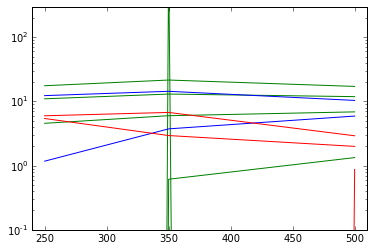

> <ipython-input-6-d6312c02a78e>(5)<module>()
-> for iz in range(nz):


In [ ]:
npop=3
all_stacked_fluxes = np.zeros([nwv,nz,nm]) #,npop])

path_5_pop = '/data/maps_cats_models/catalogs/multi_pop_lists/5pops/'
for iz in range(nz):
    #Stack one z at a time

    list_names=[]
    z_suf = ""+"-".join([str(z_lo[iz]),str(z_hi[iz])])
    for jm in range(nm):
        m_suf = ""+"-".join([str(m_lo[jm]),str(m_hi[jm])])

        file_list ='list_5pop_z-'+z_suf+'_m-'+m_suf+'_sf.csv'
        list_names.append(path_5_pop+file_list)
        file_list ='list_5pop_z-'+z_suf+'_m-'+m_suf+'_qt.csv'
        list_names.append(path_5_pop+file_list)
        file_list ='list_5pop_z-'+z_suf+'_m-'+m_suf+'_agn.csv'
        list_names.append(path_5_pop+file_list)
        #file_list ='list_5pop_z-'+z_suf+'_m-'+m_suf+'_sb.csv'
        #list_names.append(path_5_pop+file_list)
        #file_list ='list_5pop_z-'+z_suf+'_m-'+m_suf+'_loc.csv'
        #list_names.append(path_5_pop+file_list)
    stacked_fluxes =  None
    n_sources_max = None
    #print np.size(map_files)
    #print np.size(noise_files)
    #print np.size(list_names)
    #nlists =  len(list_names)
    #ra, dec = readcol.readcol(list_names[0],fsep=',',twod=False)
    stacked_fluxes = viero_quick_stack(
        map_files,
        list_names,
        noise_files)
    #all_stacked_fluxes[:,iz,:] = stacked_fluxes#[:,j] 
    print stacked_fluxes
    plt.ylim([-1e-1,3e0])
    plt.ylim([1e-1,3e2])
    plt.xlim([240,510])
    plt.yscale('log')
    for j in range(nm): 
        plt.plot(wavelength,1e3*stacked_fluxes[:,npop*j],color='b')
        plt.plot(wavelength,1e3*stacked_fluxes[:,npop*j+1],'-',color='r')
        plt.plot(wavelength,1e3*stacked_fluxes[:,npop*j+2],'-',color='g')
        #plt.plot(wavelength,1e3*stacked_fluxes[:,npop*j+3],'--',color='b')
        #plt.plot(wavelength,1e3*stacked_fluxes[:,npop*j+4],'--',color='g')
    plt.show()
    pdb.set_trace()

In [ ]:
print ra

In [ ]:




wv1=0 # here wv1=0 means start at 250
wv2=2 # and wv2=2 means end at 500
nwv=wv2-wv1+1
#xt=textoidl('\lambda [\mum]')
#yt='stacked flux [Jy]'
#xr=[100,1000]
#yr=[1e-3,3e-2]
#lot,[0],[0],xr=xr,yr=yr,/xs,/ys,/xl,/yl,xtitle=xt,ytitle=yt,charsize=1.8
#or j=0,nlists-1 do begin
#  oplot, [wavelength[wv1:wv2]],[stacked_sed[*,j]],psym=-1.*j
#  errplot, [wavelength[wv1:wv2]],[stacked_sed[*,j]-stacked_sed_err[*,j]],$
#     [stacked_sed[*,j]+stacked_sed_err[*,j]]
for j in range(nlists):
    plt.plot(wavelength,stacked_fluxes[:,j])
plt.show()